# 卷积神经网络(Convolutional Neural Networks)

[最容易理解的对卷积(convolution)的解释](https://blog.csdn.net/bitcarmanlee/article/details/54729807)

In [3]:
import numpy as np
import tensorflow as tf
from skimage import data, color
import matplotlib.pyplot as plt

%matplotlib inline

## 卷积的意义

卷积的重要的物理意义是：一个函数（如：单位响应）在另一个函数（如：输入信号）上的**加权叠加**。

对于线性时不变系统，如果知道该系统的单位响应，那么将单位响应和输入信号求卷积，就相当于把输入信号的各个时间点的单位响应 加权叠加，就直接得到了输出信号。

例子:

已知$x[0] = a, x[1] = b, x[2]=c$, 已知$y[0] = i, y[1] = j, y[2]=k$, 求$(x \otimes y)(n)$
![](./卷积1.png)

最后，把上面三个图叠加，就得到了$(x \otimes y)(n)$
![](./卷积2.png)

## 1D连续卷积

数学定义: $$(f \otimes g)(n) = \int_{-\infty}^{\infty} f(\tau)g(n-\tau)d\tau$$

例子: 做馒头

假设馒头的生产速度是 $f(t)$, 馒头生产出来之后，就会慢慢腐败，假设腐败函数为$g(t)$, 那么一天后馒头总共腐败了：
$$\int_0^{24}f(t)g(24-t)dt$$

## 离散卷积

将积分运算换成累加运算:
$$s(n) = (f\otimes g)(n) = \sum_{\tau=-\infty}^{\infty}f(\tau)g(n-\tau)$$
例子: 掷骰子

设现有两枚骰子, 这两枚骰子掷出去, 求两枚骰子点数加起来为4的概率是多少?

令$f(n), g(n)$分别代表2枚骰子点数的概率, 两枚骰子点数加起来为4的概率为：
$$f(1)g(3)+f(2)g(2)+f(3)g(1)$$
符合卷积的定义，把它写成标准的形式就是：
$$(f\otimes g)(4) = \sum_{m=1}^{3}f(4-m)g(m)$$

> 暴力解释: 扇巴掌 - -

在卷积网络的术语中, 卷积的第一个参数(函数f)通常叫作**输入**(Input), 第二个参数(函数g)叫作**核函数**(kernel function). 输出有时被称作**特征映射**(feature map)

In [ ]:
f = np.array([[2., 3, 1], [0, 5, 1], [1, 0, 8]])
g = np.array([[-1, -1., -1], [-1, 8, -1], [-1, -1, -1]])

In [ ]:
np.convolve([1, 2, 3, 4], [1, 1, 1])

## 2D离散卷积
在计算机视觉中，卷积运算基于2D 图片函数$f(m, n)$和2D卷积核$g(m, n)$，其中$f(i, j)$和$g(i, j)$仅在各自窗口有效区域存在值，其它区域视为0.此时, 2D离散卷积定义为:
$$S(m,n) = [f\otimes g](m, n) = \sum_{i=-\infty}^{\infty} \sum_{j=-\infty}^{\infty}f(i, j)g(m-i, n-j)$$
卷积是可交换的(commutative), 可以等价的写作:
$$S(m, n) = [f\otimes g](m, n) = \sum_i \sum_j f(m-i, n-j)g(i, j)$$

卷积运算的可交换性的出现是因为我们将核相对输入进行了**翻转**(filp), 这里二维的反转就是将卷积核沿x轴和y轴各翻转一次，比如：
![](./核翻转.png)


许多神经网络库会实现一个相关的函数,称为**互相关函数**(cross-correlation), 和卷积运算几乎一样但是并没有对核进行翻转:
$$S(m, n) =[f\otimes g](m, n) = \sum_i \sum_j f(m+i, n+j)g(i, j)$$

## 局部相关性

全连接层也称为稠密连接层(Dense Layer)，输出与输入的关系为:
$$o_j = \sigma(\sum_{i \in nodes(I)} w_{ij}x_i + b_j)$$
简化上述模型, 分析输入节点对输出节点的重要性分布, 仅考虑较重要的一部分输入节点而抛弃重要性较低的部分节点, 输出节点只需要与部分输入节点相连接:
$$o_j = \sigma(\sum_{i \in top(I, J, k)} w_{ij}x_i + b_j)$$
其中$top(I, J, k)$表示第I层中对第J层中的j号节点重要性最高的k个节点集合.将全连接层的$||I|| \cdot ||J||$个权值连接减少到$k\cdot ||J||$个.

根据先验知识, 可以得知图片每个像素点和周边像素点的关联度更大(位置相关). 以2D 图片数据为例，如果简单地认为与当前像素欧式距离(Euclidean Distance)小于和等于$\frac {k}{\sqrt 2}$的像素点重要性较高，欧式距离大于$\frac {k}{\sqrt 2}的像素点重要性较低，那么我们就很轻松地简化了每个像素点的重要性分布问题。

以实心网格所在的像素为参考点，它周边欧式距离小于或等于$\frac {k}{\sqrt 2}$的像素点以矩形网格表示，网格内的像素点重要性较高，网格外的像素点较低。这个高宽为𝑘的窗口称为**感受域**(Receptive Field)，它表征了每个像素对于中心像素的重要性分布情况，网格内的像素才会被考虑，网格外的像素对于中心像素会被简单忽略.

这种基于距离的重要性分布假设特性称为**局部相关性**.

当前位置的节点与大小为𝑘的窗口内的所有像素相连接，与窗口外的其它像素点无关，此时网络层的输入输出关系:
$$o_j = \sigma \left(\sum_{dist(i, j)\leq \frac {k}{\sqrt 2}} w_{ij}x_i + b_j\right)$$

## 参数共享
参数共享(parameter sharing)是指在一个模型的多个函数汇总使用相同的参数.在卷积神经网络中, 核的每一个元素都作用在输入的每一个位置上, 保证了我们只需要学习一个参数集合, 而不是对于每一位置都需要学习一个单独的参数集合.

即每个输出节点仅与感受域区域内$k \times k$个输入节点相连接，输出层节点数为$‖J‖$，则当前层的参数量为$k \times k \times ||J||$，对于每个输出节点$o_j$，均使用相同的权值矩阵$𝑾$，那么无论输出节点的数量$‖J‖$是多少，网络层的参数量总是$k\times k$。

|卷积作用|卷积核|
|:---------------------------:|:------------------------------:|
|输出原图|$\begin{bmatrix} 0 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix}$|
|边缘检测（突出边缘差异）|$\begin{bmatrix} 1 & 0 & -1 \\ 0 & 0 & 0 \\ -1 & 0 & 1 \end{bmatrix}$|
|边缘检测（突出中间值）|$\begin{bmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{bmatrix}$|
|方块模糊|$\begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix} \times \frac{1}{9}$|
|图像锐化|$\begin{bmatrix} 0 & -1 & 0 \\ -1 & 5 & -1 \\ 0 & -1 & 0 \end{bmatrix}$|
|高斯模糊|$\begin{bmatrix} 1 & 2 & 1 \\ 2 & 4 & 2 \\ 1 & 2 & 1 \end{bmatrix} \times \frac{1}{16}$|

In [ ]:
cat = data.chelsea()
cat.shape

In [ ]:
cat = cat / 255.

In [ ]:
cat_1 = np.rollaxis(cat, 2, 0)
cat_1.shape

In [ ]:
cat_2 = np.swapaxes(cat, 2, 0)
cat_2.shape

In [ ]:
plt.imshow(cat)

In [ ]:
cat_grey = color.rgb2gray(cat)
cat_grey.shape

In [ ]:
plt.imshow(cat_grey.T, cmap='gray')

**实现2D卷积**
---

In [ ]:
np.insert?

In [ ]:
image = np.ones([3,3 ])
image

In [ ]:
image = np.ones([3,3 ])
image = np.insert(image, 3, np.zeros(3), axis=0)
image = np.insert(image, 0, np.zeros(3), axis=0)
image = np.insert(image, 3, np.zeros(5), axis=1)
image = np.insert(image, 0, np.zeros(5), axis=1)
image

In [ ]:
# 多通道输入 单卷积核
def conv2d(image, kernel, padding='SAME', strides=[1]):
    # image  (height, width, in_channels)
    # kernel (filter_height, f_width, in_channels, out_channels)
    h, w, channels = image.shape
    res = np.zeros_like(image)
    kh, kw, in_c, out_c = kernel.shape
#     kernel = kernel[..., np.newaxis]
    image = np.rollaxis(image, 2, 0)  # 转为 c, h, w, 排布
    if padding == 'SAME': 
        # 需要填充一圈0(步长为1时)
        image = np.insert(image, h, np.zeros(w), axis=1)
        image = np.insert(image, 0, np.zeros(w), axis=1)
        image = np.insert(image, w, np.zeros(h + 2), axis=2)
        image = np.insert(image, 0, np.zeros(h + 2), axis=2)
#         new = np.zeros([h+2, w+2])
#         new[1:-1, 1:-1] = image
    if out_c == 1:  # 3 通道相加  输出到1个通道 
        res = res[..., 0]
        for i in range(h):  # 使用原来的h和w
            for j in range(w):
                temp = image[:, i:i+kh, j:j+kh]
                res[i, j] = np.sum(temp * kernel)
    else:  # 各通道 各自进行卷积
        for c in range(channels):
            for i in range(h):  # 使用原来的h和w
                for j in range(w):
                    temp = image[c, i:i+kh, j:j+kh]
                    res[i, j, c] = np.sum(temp * kernel)
        
    res = (res - res.min())/(res.max() - res.min()) 
    return res

In [ ]:
# kernel = np.ones((3,3 )) * 1/ 9  # 方块模糊

# kernel = np.zeros([3, 3])
# kernel[1, 1] = 1  # 原图
# kernel = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1.]])  # 突出边缘差异
kernel = np.ones((3,3 )) * -1
kernel[1, 1] = 8  # 突出中间值
kernel = np.tile(kernel[..., np.newaxis, np.newaxis], [1, 1, 3, 3])
kernel.shape

In [ ]:
cat2 = conv2d(cat, kernel)
cat2.shape

In [ ]:
plt.imshow(cat2)

**tensorflow实现2d卷积**
---

In [ ]:
tf.nn.conv2d?

In [ ]:
# [batch, in_height, in_width, in_channels]
cat1 = tf.nn.conv2d(cat[np.newaxis, ...], kernel, strides=[1], padding='SAME')

In [ ]:
cat1.shape

In [ ]:
cat1 = (cat1 - tf.reduce_min(cat1)) / (tf.reduce_max(cat1) - tf.reduce_min(cat1))

In [ ]:
plt.imshow(np.squeeze(cat1))

对于卷积, 参数共享的特殊形式使得神经网络层具有对平移**等变**(equivariance)的性质

## 步长(Stride)
步长是指感受域窗口每次移动的长度单位，对于2D输入来说，分为沿𝑥(向右)方向和𝑦(向下)方向的移动长度.

可以看到，通过设定步长𝑠，可以有效地控制信息密度的提取。当步长设计的较小时，感受域以较小幅度移动窗口，有利于提取到更多的特征信息，输出张量的尺寸也更大；当步长设计的较大时，感受域以较大幅度移动窗口，有利于减少计算代价，过滤冗余信息，输出张量的尺寸也更小.

## 填充(Padding)
经过卷积运算后的输出𝑶的高宽一般会小于输入𝑿的高宽，即使是步长s = 1时，输出𝑶的高宽也会略小于输入𝑿高宽. 

为了让输出𝑶的高宽能够与输入𝑿的相等，一般通过在原输入𝑿的高和宽维度上面进行填充(Padding)若干无效元素操作，得到增大的输入𝑿′

卷积神经层地输出尺寸$[b, h', w', c_{out}]$由卷积核的数量$c_{out}$卷积核的大小𝑘，步长𝑠，填充数𝑝(只考虑上下填充数量$𝑝_ℎ$相同，左右填充数量$𝑝_𝑤$相同的情况)以及输入𝑿的高宽ℎ/𝑤共同决定:
$$h' = \frac {h + 2\cdot p_h - k}{s} + 1 \\
w' = \frac {w + 2 \cdot p_w -k}{s} +  1
$$


In [ ]:
x = tf.random.normal([2, 5, 5, 3])  # 3通道 宽高为5 
w = tf.random.normal([3, 3, 3, 4])  # [k, k, cin, cout]  3通道输入  4个3x3的卷积核
out = tf.nn.conv2d(x, w, strides=1, padding=[[0,0],[0,0],[0,0],[0,0]])  # 不填充
out.shape

其中padding 参数的设置格式为：

padding=[[0,0],[上,下],[左,右],[0,0]]

In [ ]:
out = tf.nn.conv2d(x, w, strides=1, padding=[[0,0],[1,1],[1,1],[0,0]])
out.shape

In [ ]:
out = tf.nn.conv2d(x, w, strides=1, padding='SAME')  # 步长为1  SAME 模式下 输出与输入同大小
out.shape

In [ ]:
out = tf.nn.conv2d(x, w, strides=1, padding='VALID')
out.shape

**卷积层**
---


In [45]:
from tensorflow.keras import layers, Sequential, datasets, losses, optimizers, metrics

In [ ]:
layers.Conv2D?

In [ ]:
# 下创建了4 个3 × 3大小的卷积核的卷积层，步长为1，padding 方案为'SAME'
layer = layers.Conv2D(4, kernel_size=3, padding='SAME', strides=1)
out = layer(x)
out.shape

In [ ]:
# h=3, w=3, c_in=3 c_out=4
layer.trainable_variables

In [ ]:
# 4个3X4大小卷积核, 竖直方向步长2 水平方向步长1
layer = layers.Conv2D(4, kernel_size=(3, 4), padding='SAME', strides=(2, 1))

## LeNet-5
LeNet-5是由$LeCun$ 提出的一种用于识别手写数字和机器印刷字符的卷积神经网络. 一共包含7层（输入层不作为网络结构），分别由2个卷积层、2个下采样层和3个连接层组成.

In [12]:
data = datasets.mnist.load_data()
(X_train, y_train), (X_dev, y_dev) = data

In [16]:
X_train[0].shape

(28, 28)

3


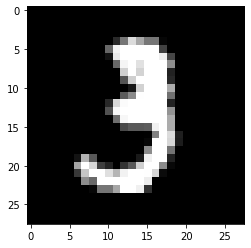

In [19]:
print(y_train[10])
plt.imshow(X_train[10], cmap='gray')

In [38]:
def preprocessing(X, y):
    X = tf.cast(X, dtype=tf.float32) / 255.
    # X = tf.reshape(X, (-1, 28*28))
    y = tf.cast(y, dtype=tf.int32)
    return X, y

In [52]:
train_db = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_db = tf.data.Dataset.from_tensor_slices((X_dev, y_dev))
train_db = train_db.shuffle(100000).batch(256).map(preprocessing).repeat(30)
test_db = test_db.shuffle(100000).batch(256).map(preprocessing)

In [40]:
X1, y1 = next(iter(train_db))
X1.shape, y1.shape

(TensorShape([256, 28, 28]), TensorShape([256]))

In [53]:
network = Sequential([
    layers.Conv2D(6, kernel_size=3, strides=1),  # 6个 3X3的 卷积核 6 * 9 + 6 = 60个参数  
    layers.MaxPooling2D(pool_size=2, strides=2),  # 高宽各减半
    layers.ReLU(),
    layers.Conv2D(16, kernel_size=3, strides=1), 
    layers.MaxPooling2D(pool_size=2, strides=2),  # 高宽各减半
    layers.ReLU(),
    layers.Flatten(),  # 展平 方便全连接层处理
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10)
])
network.build(input_shape=(None, 28, 28, 1))  # 28X28 1通道
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  60        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_2 (ReLU)               multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  880       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_3 (ReLU)               multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                 

In [41]:
# 交叉熵
criten = losses.CategoricalCrossentropy(from_logits=True) 
optimizer = optimizers.Adam(0.001)

In [42]:
optimizer.apply_gradients?

Signature: optimizer.apply_gradients(grads_and_vars, name=None)
Docstring:
Apply gradients to variables.

This is the second part of `minimize()`. It returns an `Operation` that
applies gradients.

Args:
  grads_and_vars: List of (gradient, variable) pairs.
  name: Optional name for the returned operation.  Default to the name
    passed to the `Optimizer` constructor.

Returns:
  An `Operation` that applies the specified gradients. The `iterations`
  will be automatically increased by 1.

Raises:
  TypeError: If `grads_and_vars` is malformed.
  ValueError: If none of the variables have gradients.
File:      ~/.local/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py
Type:      method


In [49]:
metric_acc = metrics.Accuracy()


In [54]:
# loss = []
acc = []
metric_acc.reset_states()
for step, (x, y) in enumerate(train_db):
    with tf.GradientTape() as tape:
        x = tf.expand_dims(x, axis=3)  # [b, 28, 28, 1]
        out = network(x)
        y_onehot = tf.one_hot(y, depth=10)
        cost = criten(y_onehot, out)
    grads = tape.gradient(cost, network.trainable_variables)
    optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
    if step % 100 == 0:
        print(f'step:{step} cost:{float(cost)}', )
        for x, y in test_db:
            x = tf.expand_dims(x, axis=3)
            out = network(x)
            # 可以不进过softmax
            y_pred = tf.argmax(out, axis=-1)
            metric_acc.update_state(y, y_pred)
        print(f"dev 正确率:{float(metric_acc.result())}")
        acc.append(float(metric_acc.result()))


step:0 cost:2.313047409057617
dev 正确率:0.18780000507831573
step:100 cost:0.10444694012403488
dev 正确率:0.575950026512146
step:200 cost:0.06578396260738373
dev 正确率:0.7103000283241272
step:300 cost:0.05805310606956482
dev 正确率:0.7777000069618225
step:400 cost:0.056566882878541946
dev 正确率:0.8187000155448914
step:500 cost:0.039628222584724426
dev 正确率:0.8462666869163513
step:600 cost:0.07804673165082932
dev 正确率:0.8661999702453613
step:700 cost:0.07342112064361572
dev 正确率:0.881262481212616
step:800 cost:0.0555611252784729
dev 正确率:0.8929444551467896
step:900 cost:0.07327509671449661
dev 正确率:0.9024699926376343
step:1000 cost:0.025775428861379623
dev 正确率:0.9102363586425781
step:1100 cost:0.0504230298101902
dev 正确率:0.9166833162307739
step:1200 cost:0.006781408563256264
dev 正确率:0.9221461415290833
step:1300 cost:0.015395808033645153
dev 正确率:0.926885724067688
step:1400 cost:0.034457016736269
dev 正确率:0.9310399889945984
step:1500 cost:0.03598139062523842
dev 正确率:0.9346625208854675
step:1600 cost:0.022872